In [1]:
!pip install datasets transformers evaluate
!pip install -U accelerate

In [2]:
from torch.utils.data import Dataset
from datasets import load_dataset
from tqdm import tqdm
import numpy as np
from torch import nn
import torch
from transformers import AutoTokenizer


In [3]:
dataset = load_dataset("copenlu/answerable_tydiqa")

train_set = dataset["train"]
validation_set = dataset["validation"]

def get_answer_start(row):
  return row["annotations"]["answer_start"][0]

def get_answer(row):
  return row["annotations"]["answer_text"][0]

def get_document(row):
  return row["document_plaintext"]

def get_question(row):
  return row["question_text"]

def oracle(answer, document):
  return answer != "" and answer in document

def get_language(dataset, lang):
  return dataset.filter(lambda x: x["language"] == lang)#[row for row in dataset if row['language'] == lang]

In [4]:
train_arabic = get_language(train_set, "arabic")
val_arabic = get_language(validation_set, "arabic")

train_bengali = get_language(train_set, "bengali")
val_bengali = get_language(validation_set, "bengali")

train_indonesian = get_language(train_set, "indonesian")
val_indonesian = get_language(validation_set, "indonesian")

In [5]:
train_arabic_tt = train_arabic.train_test_split(test_size=0.2)
train_bengali_tt = train_bengali.train_test_split(test_size=0.2)
train_indonesian_tt = train_indonesian.train_test_split(test_size=0.2)

In [6]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")

In [7]:
def preprocess(examples):

    questions = [q.strip() for q in examples["question_text"]]

    inputs = tokenizer(

        questions,

        examples["document_plaintext"],

        max_length=512,

        truncation="only_second",

        return_offsets_mapping=True,

        padding="max_length",

    )

    offset_mapping = inputs.pop("offset_mapping")

    answers = examples["annotations"]

    start_positions = []

    end_positions = []

    for i, offset in enumerate(offset_mapping):

        answer = answers[i]

        start_char = answer["answer_start"][0]

        end_char = answer["answer_start"][0] + len(answer["answer_text"][0])

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context

        idx = 0

        while sequence_ids[idx] != 1:

            idx += 1

        context_start = idx

        while sequence_ids[idx] == 1:

            idx += 1

        context_end = idx - 1

        # If the answer is not fully inside the context, label it (0, 0)

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:

            start_positions.append(0)

            end_positions.append(0)

        else:

            # Otherwise it's the start and end token positions

            idx = context_start

            while idx <= context_end and offset[idx][0] <= start_char:

                idx += 1

            start_positions.append(idx - 1)

            idx = context_end

            while idx >= context_start and offset[idx][1] >= end_char:

                idx -= 1

            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions

    inputs["end_positions"] = end_positions

    return inputs

In [8]:
tokenized_train_bn = train_bengali_tt.map(preprocess, batched=True, remove_columns=train_bengali_tt["train"].column_names)

Map:   0%|          | 0/3823 [00:00<?, ? examples/s]

Map:   0%|          | 0/956 [00:00<?, ? examples/s]

In [9]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [10]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained("distilbert-base-multilingual-cased")

Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
from huggingface_hub import notebook_login

notebook_login()

In [16]:
training_args = TrainingArguments(

    output_dir="my_awesome_qa_model",

    evaluation_strategy="epoch",

    learning_rate=2e-5,

    per_device_train_batch_size=16,

    per_device_eval_batch_size=16,

    num_train_epochs=3,

    weight_decay=0.01,

    push_to_hub=True

)

trainer = Trainer(

    model=model,

    args=training_args,

    train_dataset=tokenized_train_bn["train"],

    eval_dataset=tokenized_train_bn["test"],

    tokenizer=tokenizer,

    data_collator=data_collator,

)

trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,1.700044
2,No log,1.734977
3,1.029600,1.783050


TrainOutput(global_step=717, training_loss=0.9339619826738472, metrics={'train_runtime': 655.9566, 'train_samples_per_second': 17.484, 'train_steps_per_second': 1.093, 'total_flos': 1498460404267008.0, 'train_loss': 0.9339619826738472, 'epoch': 3.0})

In [49]:
from transformers import pipeline

question_answerer = pipeline("question-answering", model="my_awesome_qa_model")

answerable_scores = []
non_answerable_scores = []

np.mean([(question_answerer(question=get_question(row), context=get_document(row))["score"] >= 0.2) == oracle(get_answer(row), get_document(row)) for row in val_bengali])

#for row in val:
#  question = get_question(row)
#  document = get_document(row)
#  score =
#  if get_answer(row) == "":
#    non_answerable_scores.append(score)
#  else:
#    answerable_scores.append(score)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


0.6964285714285714

In [35]:
answerable_scores = np.array(answerable_scores)

non_answerable_scores = np.array(non_answerable_scores)

In [47]:
print(len(answerable_scores) + len(non_answerable_scores))

for threshold in range(0, 200, 1):
  threshold = threshold/1000
  print(threshold, np.sum(answerable_scores >= threshold) + np.sum(non_answerable_scores < threshold))

956
0.0 474
0.001 717
0.002 731
0.003 743
0.004 751
0.005 754
0.006 756
0.007 756
0.008 761
0.009 761
0.01 760
0.011 759
0.012 759
0.013 760
0.014 760
0.015 763
0.016 761
0.017 761
0.018 762
0.019 765
0.02 762
0.021 763
0.022 760
0.023 761
0.024 760
0.025 761
0.026 760
0.027 760
0.028 759
0.029 759
0.03 756
0.031 756
0.032 756
0.033 756
0.034 756
0.035 757
0.036 758
0.037 758
0.038 755
0.039 753
0.04 753
0.041 750
0.042 750
0.043 748
0.044 749
0.045 749
0.046 749
0.047 749
0.048 747
0.049 748
0.05 747
0.051 747
0.052 745
0.053 747
0.054 748
0.055 748
0.056 747
0.057 747
0.058 747
0.059 746
0.06 746
0.061 746
0.062 746
0.063 744
0.064 745
0.065 745
0.066 743
0.067 744
0.068 742
0.069 742
0.07 741
0.071 741
0.072 740
0.073 740
0.074 739
0.075 737
0.076 738
0.077 738
0.078 739
0.079 738
0.08 739
0.081 739
0.082 738
0.083 738
0.084 739
0.085 740
0.086 740
0.087 740
0.088 741
0.089 740
0.09 740
0.091 739
0.092 740
0.093 738
0.094 737
0.095 737
0.096 739
0.097 739
0.098 738
0.099 737
0.1 735

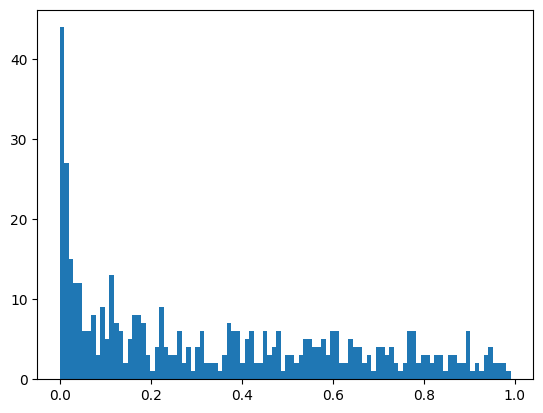

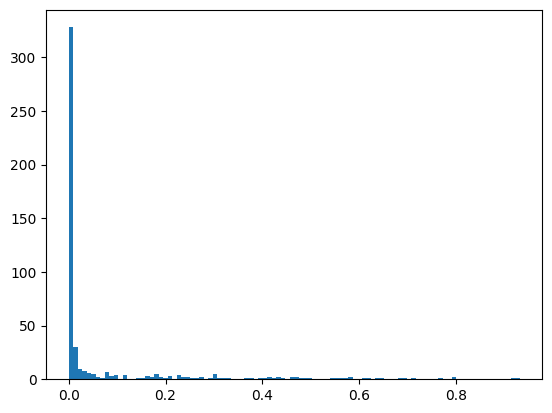

In [34]:
import matplotlib.pyplot as plt
import numpy as np

y = np.ones(len(answerable_scores))
plt.hist(answerable_scores, bins = 100)
plt.show()
plt.hist(non_answerable_scores, bins = 100)
plt.show()